In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import altair as alt

%load_ext autoreload
%autoreload 2
def save(model, filename='bestmodel.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def save_feature_selection(cols, filename='feat_selection.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(cols, handle, protocol=pickle.HIGHEST_PROTOCOL)

def submit(model):
    pred = model.predict(final_test)
    final_test['SalePrice'] = np.exp(pred)
    final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

## Import data

In [2]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
f = open("output/feat_selection.pickle","rb")
cols = pickle.load(f)

In [3]:
def inv_y(transformed_y):
    return np.exp(transformed_y)


## Make preprocessing pipelines

In [4]:
from sklearn.impute import SimpleImputer
# todo multivariate imputation, possibly with pipelines for numeric and categorical data

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
# https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler/51237727
# don't know features are normal so just going with minmax scalar atm

from sklearn.preprocessing import OneHotEncoder
#https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
#The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.
# So don't use pandas get dummies, but a OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

numeric_transformer = Pipeline(steps=[
    ('impute_num', SimpleImputer(strategy='median')),
    ('scale_num', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    # ('label_encode', preprocessing.LabelEncoder()),
    ('onehot_cat', OneHotEncoder(handle_unknown="ignore"))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_x),
        ('category', categorical_transformer, cat_x)])


def densify(x): # needs to use a function, lambda gives problems with pickling
    return x.todense()


In [5]:
class Decorator(object):
    def __init__(self, arg):
        self.arg = arg
    def __call__(self, cls):
        class Wrapped(cls):
            classattr = self.arg
            def transform(self, value):
                return value * 2
        return Wrapped

from utils.sklearn_custom_steps import DFSimpleImputer, DFOneHotEncoder,DFMinMaxScaler,DFColumnTransformer

In [6]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_selector

def get_pipeline(model, outlier = False, impute=True,scale=True,onehot=True,label=False,to_dense=False):
    if outlier:
        print('outlier removal not implemented yet')
        return
    cat_steps = []
    if impute: cat_steps.append(('impute_cat', DFSimpleImputer(strategy='most_frequent')))
    # if impute: cat_steps.append(('impute_cat', IterativeImputer(max_iter=10, random_state=0)))
    if label: cat_steps.append(('label_encode', preprocessing.LabelEncoder()))
    if onehot: cat_steps.append(('onehot_cat', DFOneHotEncoder(handle_unknown="ignore")))
    # cat_steps.append(('to_pandas_cat', To_Pandas(cat_x)))
    categorical_transformer = Pipeline(steps=cat_steps)

    num_steps = []
    if impute: num_steps.append(('impute_num', DFSimpleImputer(strategy='mean')))
    # if impute: num_steps.append(('impute_num', IterativeImputer(max_iter=10, random_state=0)))
    if scale: num_steps.append(('scale_num', DFMinMaxScaler()))
    # num_steps.append(('to_pandas_num', To_Pandas(num_x)))
    numeric_transformer = Pipeline(steps=num_steps)

    preprocessor = DFColumnTransformer(transformers=[
        ('numeric', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('category', categorical_transformer, make_column_selector(dtype_exclude=np.number)),
        # ('labeling',LabelEncoder(),ord_x)
        ])

    final_pipe = [('preprocess', preprocessor)]
    if to_dense: final_pipe.append(('to_dense',FunctionTransformer(densify, accept_sparse=True)))
    final_pipe.append(('model',model))

    return Pipeline(steps=final_pipe)
    

## Collection of models with hyperparameters

In [7]:
from utils.model_hyperparameters import models
models.keys()


dict_keys(['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'svm.SVR', 'KNeighborsRegressor', 'RandomForestRegressor', 'AutoCatBoostRegressor', 'xgb.XGBRegressor', 'lgb.LGBMRegressor', 'HistGradientBoostingRegressor', 'GradientBoostingRegressor', 'LassoCV', 'KernelRidge', 'MLPRegressor'])

## Rough test of all models

In [8]:
def cross_val_models(to_test,train_x=train_x):
    for name in to_test:
        pipe = get_pipeline(models[name].model, **models[name].preprocess)
        # score = -1 * cross_val_score(pipe, train_x, train_y,cv=3,scoring='neg_root_mean_squared_error')
        # below is necessary for looking at train scores
        num_fold = 5
        scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
        # scoring is identical to 
        # make_scorer(mean_squared_error,greater_is_better=False, root=False,squared=False)
        # neg_mean_squared_log_error
        print(f"{name:<30}train {-1 * sum(scores['train_score'])/num_fold:.5f}, test {-1 * sum(scores['test_score'])/num_fold:.5f}")

# def test_model(model):
#         num_fold = 5
#         pipe = get_pipeline(model)
#         scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
#         print(f"train {-1 * sum(scores['train_score'])/num_fold:.3f}, test {-1 * sum(scores['test_score'])/num_fold:.3f}")
#         return pipe

def test_model(model,train_x = train_x,param=None):
    print(train_x.shape)

    num_fold = 5
    if not param: param = {}
    pipe = get_pipeline(model,**param)
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    print(f"test {-1 * sum(scores['test_score'])/num_fold:.7f}, train {-1 * sum(scores['train_score'])/num_fold:.7f}")
    return pipe

In [12]:
cross_val_models(models)

KeyboardInterrupt: 

In [ ]:
cross_val_models(models, train_x=train_x[cols['selected']])

## Tune number of iterations for Catboost

In [32]:
from utils.model_hyperparameters import AutoCatBoostRegressor
pipe = get_pipeline(AutoCatBoostRegressor(silent=True))
x = pipe[:-1].fit_transform(train_x[:1000])
val_x = pipe[:-1].transform(train_x[1000:])
fitted = pipe.named_steps['model'].fit(x,train_y[:1000],eval_set=(
    val_x,train_y[1000:]))

In [73]:
# onehot in pipeline gives better result and is 5x faster than passing cat to catboost
from aoc import timeit
with timeit(''): test_model(AutoCatBoostRegressor(silent=True),param={'onehot':True})

(1414, 177)
INFO:root:, time: 1.2184464852015178
test 0.1116285, train 0.0335589


In [54]:
lr = [0.01,0.03,0.05,0.08,0.1,0.12,0.15,0.2]
lr = [0.03,0.035,0.04,0.046077001839876175,0.05,0.05,0.06]

In [59]:
from utils.model_hyperparameters import AutoCatBoostRegressor
for l in lr:
    pipe = get_pipeline(AutoCatBoostRegressor(silent=True,learning_rate=l,use_best_model=True,random_seed=42,iterations=1200))
    x = pipe[:-1].fit_transform(train_x[:1000])
    val_x = pipe[:-1].transform(train_x[1000:])
    fitted = pipe.named_steps['model'].fit(x,train_y[:1000],eval_set=(
        val_x,train_y[1000:]))
    print(f'{l:.10f}, {fitted.get_best_iteration():.5f},{fitted.best_score_}')

0.0300000000, 1148.00000,{'learn': {'RMSE': 0.034270830420753594}, 'validation': {'RMSE': 0.1082158776900088}}
0.0350000000, 959.00000,{'learn': {'RMSE': 0.028597792254358566}, 'validation': {'RMSE': 0.10810391342626736}}
0.0400000000, 808.00000,{'learn': {'RMSE': 0.02585967598484225}, 'validation': {'RMSE': 0.1087534427303903}}
0.0460770018, 607.00000,{'learn': {'RMSE': 0.02089384253669725}, 'validation': {'RMSE': 0.10899765464229043}}
0.0500000000, 790.00000,{'learn': {'RMSE': 0.017480529885352945}, 'validation': {'RMSE': 0.10916605794959813}}
0.0500000000, 790.00000,{'learn': {'RMSE': 0.017480529885352945}, 'validation': {'RMSE': 0.10916605794959813}}
0.0600000000, 731.00000,{'learn': {'RMSE': 0.012825372002920131}, 'validation': {'RMSE': 0.1083015915748979}}


In [60]:
fits = {}
fits['learn'] = list(fitted.get_evals_result()['learn'].values())[0]
fits['validation'] = list(fitted.get_evals_result()['validation'].values())[0]
df = pd.DataFrame.from_dict(fits)
df.reset_index(inplace=True)
df =  df.melt('index',var_name= 'type',value_name='score')
fitted.get_evals_result()

alt.Chart(df).mark_line().encode(
    x='index',
    y='score',
    color='type',
)

alt.Chart(...)

## Hyperparameter tuning

In [9]:
from skopt import BayesSearchCV, callbacks
from skopt.space import Real, Categorical, Integer

TRAIN_TIME = 1800
NUM_ITERATIONS = 200
NO_IMPROVEMENT_STOP_THRES = 30

def gen_opt_settings(model_name):
    model = {'model': [models[model_name].model]}
    for k,v in models[model_name].hyper.items():
        model['model__'+k] = v
    if models[model_name].hyper:
        return (model, NUM_ITERATIONS)
    else:
        return (model, 1)

def optimize_model(model_name,train_x = train_x):
    print('running', model_name)
    def no_improvement_detector(optim_result):
        score = opt.best_score_
        # print(optim_result.x)
        print(f"{'best score':15}{score}")
        if score > opt.train_status['current_score']:
            opt.train_status['current_score'] = score
            opt.train_status['not_improving'] = 0
        else:
            opt.train_status['not_improving'] += 1
            if opt.train_status['not_improving'] == opt.train_status['stop_thres']: return True
    checkpointsaver = callbacks.CheckpointSaver("output/" + model_name + "_skopt.pkl")
    deadlinestopper = callbacks.DeadlineStopper(TRAIN_TIME)

    opt = BayesSearchCV(
        get_pipeline(models[model_name].model, **models[model_name].preprocess),
        [gen_opt_settings(model_name)],
        cv=5, 
        scoring = 'neg_root_mean_squared_error',
        return_train_score = True,
        random_state = 112 
        )
    opt.train_status = { 'current_score': -100, 'not_improving': 0, 'stop_thres' :NO_IMPROVEMENT_STOP_THRES}

    opt.fit(train_x,train_y, callback = [no_improvement_detector,checkpointsaver,deadlinestopper])
    return opt

def hashing(self): return 8398398478478 
CatBoostRegressor.__hash__ = hashing

to_test = [k for k in models]
to_test = [
    'AutoCatBoostRegressor',
    'svm.SVR',
    'KernelRidge',
    'HistGradientBoostingRegressor',
    'GradientBoostingRegressor',
    'svm.SVR',
    'Lasso',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']
results = {}
for name in to_test:
    results[name] = optimize_model(name, train_x)

running AutoCatBoostRegressor
kwarg {}
kwarg {}
kwarg {}
kwarg {}
kwarg {}
best score     -0.11792685298824686
kwarg {}


KeyboardInterrupt: 

In [ ]:
save(results,'hyper_tuning_results.pickle')
# f = open("output/hyper_tuning_results.pickle","rb")
# results = pickle.load(f)

In [ ]:
#summarize tuning results
for model in results:
    best_run = results[model].cv_results_['rank_test_score'].index(1)
    mean_test_score = -1 * results[model].cv_results_['mean_test_score'][best_run]
    std_test_score = results[model].cv_results_['std_test_score'][best_run]
    mean_train_score = -1 * results[model].cv_results_['mean_train_score'][best_run]
    mean_score_time = results[model].cv_results_['mean_score_time'][best_run]
    best_params = results[model].best_params_

    # print(f"{model:<30} Best score {mean_test_score:.4f} std {std_test_score:.4f} train {mean_train_score:.4f} time {mean_score_time:.4f}")
    print(f"{model:<30} Best score {mean_test_score:.4f} std {std_test_score:.4f} train {mean_train_score:.4f} time {mean_score_time:.4f}")

In [ ]:
HistGradientBoostingRegressor  Best score 0.1215 std 0.0056 train 0.0767 time 0.1505
GradientBoostingRegressor      Best score 0.1199 std 0.0059 train 0.0756 time 0.2613
svm.SVR                        Best score 0.1119 std 0.0084 train 0.0939 time 0.1793
Lasso                          Best score 0.1076 std 0.0056 train 0.0948 time 0.2734
AutoCatBoostRegressor          Best score 0.1146 std 0.0053 train 0.0530 time 0.2043
xgb.XGBRegressor               Best score 0.1127 std 0.0050 train 0.0757 time 0.1481
lgb.LGBMRegressor              Best score 0.1142 std 0.0045 train 0.0848 time 0.2307

In [13]:
# Assert to see if it matches the BayesSearchCV results. Not necessary since it matches
for model in results:
    pipe = results[model].best_estimator_
    num_fold = 5
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    print(f"{model:<30}train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")


svm.SVR                       train 0.0961, test 0.1163
ElasticNet                    train 0.0956, test 0.1080
RandomForestRegressor         train 0.0504, test 0.1306
CatBoostRegressor             train 0.0810, test 0.1189
xgb.XGBRegressor              train 0.0796, test 0.1132
lgb.LGBMRegressor             train 0.0734, test 0.1139


## Experimental runs

In [23]:
model = test_model(svm.SVR(C=66,gamma=6.105402296585326e-05))

(1414, 177)
test 0.1156005, train 0.1067726


In [31]:
model = test_model(GradientBoostingRegressor(n_estimators=2200,
                 learning_rate=0.05,
                   max_depth=3,
                   max_features='sqrt',
                   min_samples_leaf=5,
                   min_samples_split=12,
                   loss='huber'))

(1414, 177)
test 0.1101207, train 0.0457746


In [33]:
model = test_model(lgb.LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2, feature_fraction_seed=7,
              importance_type='split', learning_rate=0.05, max_bin=50,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=700, n_jobs=-1, num_leaves=4,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0))

(1414, 177)
test 0.1129615, train 0.0583715


In [ ]:
b

## Stacking best models from hyperparam

In [11]:
from sklearn.ensemble import StackingRegressor

to_stack_list = [
    'ElasticNet',
    'RandomForestRegressor',
    'CatBoostRegressor',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']

to_stack_list = to_test
to_stack = [(model_name, results[model_name].best_estimator_) for model_name in to_stack_list]

model = StackingRegressor(to_stack, final_estimator = (LinearRegression()), passthrough = False)
num_fold = 5
scores = cross_validate(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
print(f"stacking model train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")

stacking model train 0.0774, test 0.1054


In [12]:
model.fit(train_x,train_y)

StackingRegressor(cv=None,
                  estimators=[('HistGradientBoostingRegressor',
                               Pipeline(memory=None,
                                        steps=[('preprocess',
                                                DFColumnTransformer(n_jobs=None,
                                                                    remainder='drop',
                                                                    sparse_threshold=0.3,
                                                                    transformer_weights=None,
                                                                    transformers=[('numeric',
                                                                                   Pipeline(memory=None,
                                                                                            steps=[('impute_num',
                                                                                                    DFSimpleImputer(add_indicator=

## Saving

In [24]:
train_info = (train_x, train_y, num_x, cat_x)
with open('output/train_info.pickle', 'wb') as handle:
    pickle.dump(train_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# model = get_pipeline(CatBoostRegressor(silent=True,cat_features=cat_x),onehot=False)
# model = model.fit(train_x,train_y)
submit(model)
save(model,'ensemble.pickle')

In [10]:
save(model,'model_catboostvanilla')

## FastAI

In [66]:
import fastai2
# from fastai2.tabular.all import *
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
df = train_x
df['SalePrice'] = train_y

In [49]:
Pipeline

fastcore.transform.Pipeline

In [63]:
pipe = get_pipeline(Lasso(),onehot=False)
df = pipe.named_steps['preprocess'].fit_transform(train_x)
df['SalePrice'] = train_y

In [65]:
df['SalePrice'].head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [67]:
num_x,cat_x = cont_cat_split(df, max_card=9000, dep_var='SalePrice')

In [68]:
df['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1454    12.128117
1455    12.072547
1456    12.254868
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1414, dtype: float64

In [69]:
dls = TabularDataLoaders.from_df(df, path='bla', y_names="SalePrice",
    cat_names = cat_x,
    cont_names = num_x,
    procs = [Categorify, FillMissing, Normalize])

In [70]:
learn = tabular_learner(dls, layers=[1000,500], loss_func=F.mse_loss, # or func MSELossFlat()
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), 
                        metrics=rmse)

learn = tabular_learner(dls, loss_func=MSELossFlat(), 
                        metrics=rmse)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.00363078061491251)

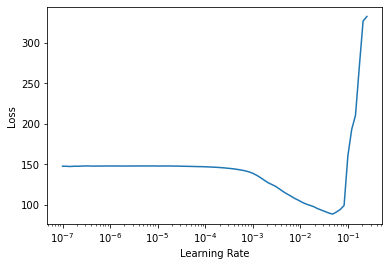

In [71]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(15, 6.918309954926372e-05, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,0.720350,1.260966,1.122927,00:07
1,0.634628,1.274511,1.128943,00:06
2,0.633233,1.154903,1.074664,00:06
3,0.722872,1.229494,1.108825,00:06
4,0.635765,0.975592,0.987721,00:07
5,0.672587,1.005359,1.002676,00:06
6,0.610774,1.013499,1.006727,00:06
7,0.514983,0.915475,0.956805,00:06
8,0.512361,0.657616,0.810935,00:07
9,0.509264,0.903293,0.950417,00:06


In [83]:
learn.metrics.items

In [88]:
final_test['BsmtFinSF1'] = final_test['BsmtFinSF1'].fillna(0)
final_test['BsmtFinSF2'] = final_test['BsmtFinSF2'].fillna(0)
final_test['BsmtUnfSF'] = final_test['BsmtUnfSF'].fillna(0)
final_test['TotalBsmtSF'] = final_test['TotalBsmtSF'].fillna(0)
final_test['BsmtFullBath'] = final_test['BsmtFullBath'].fillna(0)
final_test['KitchenQual'] = final_test['KitchenQual'].fillna(train_x['KitchenQual'].mean())
final_test['Functional'] = final_test['Functional'].fillna(train_x['Functional'].mean())
final_test['GarageCars'] = final_test['GarageCars'].fillna(0)
final_test['GarageArea'] = final_test['GarageArea'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(0)
final_test['SimplKitchenQual'] = final_test['SimplKitchenQual'].fillna(0)
final_test['KitchenScore'] = final_test['KitchenScore'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(train_x['SimplFunctional'].mean())
final_test['SimplKitchenScore'] = final_test['SimplKitchenScore'].fillna(train_x['SimplKitchenScore'].mean())
final_test['TotalBath'] = final_test['TotalBath'].fillna(1)
final_test['AllSF'] = final_test['AllSF'].fillna(train_x['AllSF'].mean())
final_test['AllSF_2'] = final_test['AllSF_2'].fillna(train_x['AllSF_2'].mean())
final_test['AllSF_3'] = final_test['AllSF_3'].fillna(train_x['AllSF_3'].mean())
final_test['AllSF_sq'] = final_test['AllSF_sq'].fillna(train_x['AllSF_sq'].mean())
final_test['GarageCars_2'] = final_test['GarageCars_2'].fillna(train_x['GarageCars_2'].mean())
final_test['GarageCars_3'] = final_test['GarageCars_3'].fillna(train_x['GarageCars_3'].mean())
final_test['GarageCars_sq'] = final_test['GarageCars_sq'].fillna(train_x['GarageCars_sq'].mean())
final_test['TotalBath_2'] = final_test['TotalBath_2'].fillna(train_x['TotalBath_2'].mean())
final_test['TotalBath_3'] = final_test['TotalBath_3'].fillna(train_x['TotalBath_3'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['KitchenQual_2'] = final_test['KitchenQual_2'].fillna(train_x['KitchenQual_2'].mean())
final_test['KitchenQual_3'] = final_test['KitchenQual_3'].fillna(train_x['KitchenQual_3'].mean())
final_test['KitchenQual_sq'] = final_test['KitchenQual_sq'].fillna(train_x['KitchenQual_sq'].mean())
final_test['BsmtFinSF1_log'] = final_test['BsmtFinSF1_log'].fillna(train_x['BsmtFinSF1_log'].mean())
final_test['BsmtFinSF2_log'] = final_test['BsmtFinSF2_log'].fillna(train_x['BsmtFinSF2_log'].mean())
final_test['BsmtUnfSF_log'] = final_test['BsmtUnfSF_log'].fillna(train_x['BsmtUnfSF_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtFullBath_log'] = final_test['BsmtFullBath_log'].fillna(train_x['BsmtFullBath_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtHalfBath_log'] = final_test['BsmtHalfBath_log'].fillna(train_x['BsmtHalfBath_log'].mean())
final_test['GarageCars_log'] = final_test['GarageCars_log'].fillna(train_x['GarageCars_log'].mean())
final_test['GarageArea_log'] = final_test['GarageArea_log'].fillna(train_x['GarageArea_log'].mean())
final_test['AllSF_log'] = final_test['AllSF_log'].fillna(train_x['AllSF_log'].mean())
final_test['BsmtHalfBath'] = final_test['BsmtHalfBath'].fillna(train_x['BsmtHalfBath'].mean())

# test_to = to.new(final_test)
# test_to.process()

In [89]:
final_test['MiscFeature']=np.nan
dl = learn.dls.test_dl(final_test)
res= learn.get_preds(dl=dl)

In [90]:
final_test['SalePrice'] = np.exp(res[0].numpy())
final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

In [91]:
final_test['SalePrice'][:100]

0      67190.859375
1      16630.333984
2      49383.144531
3      77657.109375
4     110854.671875
          ...      
95     55282.664062
96     88132.164062
97     85025.382812
98     67225.734375
99     12819.370117
Name: SalePrice, Length: 100, dtype: float32

In [24]:
final_test['SalePrice'].describe()

count    1.459000e+03
mean     1.222441e+05
std      9.191402e+04
min      1.197349e+00
25%      7.746236e+04
50%      1.007307e+05
75%      1.361005e+05
max      1.448536e+06
Name: SalePrice, dtype: float64

## Borutashap for feature selection

https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677

In [10]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)

from BorutaShap import BorutaShap
from utils.model_hyperparameters import AutoCatBoostRegressor
cat = CatBoostRegressor(max_depth=5,silent=True)
pipe = get_pipeline(BorutaShap(model = cat, importance_measure='shap',
                              classification=False),onehot=False)

In [13]:
feat_selector = pipe.fit(train_x,train_y,model__n_trials=50)

100%|██████████| 50/50 [39:18<00:00, 47.16s/it]39 82 95 (accept,tentative,reject)
39 attributes confirmed important: ['TotalBath_3', 'BsmtFinSF1_log', 'SaleCondition', 'LotArea_log', 'TotalBath_sq', 'YearRemodAdd', 'SimplOverallQual_2', 'AllSF_2', 'KitchenQual_2', 'Fireplaces', 'GarageFinish', 'Fireplaces_log', 'OverallQual', 'CentralAir', 'OverallQual_sq', 'OverallQual_3', 'AllPorchSF', 'AllSF_3', 'AllSF', 'MSZoning', 'OverallGrade', 'LotArea', 'BsmtQual', 'YearRemodAdd_log', 'AllSF_log', 'YearBuilt', 'Neighborhood', 'KitchenQual_sq', 'Functional', 'TotalBath', 'OverallCond', 'Condition1', 'GarageYrBlt', 'OverallQual_2', 'AllSF_sq', 'TotalBath_2', 'AllFlrsSF_2', 'BsmtFinType1', 'BsmtFinSF1']
95 attributes confirmed unimportant: ['ScreenPorch_log', 'BsmtFullBath_log', 'KitchenAbvGr_log', 'MasVnrArea', 'BsmtFinType2', 'MasVnrType', 'OpenPorchSF', 'LotFrontage_log', 'FireplaceQu', 'MiscFeature', 'SimplPoolQC', 'SimplExterGrade', 'SimplBsmtCond', 'GarageType', 'hasbsmt', 'SimplPoolScore',

In [26]:
cols = feat_selector.named_steps['model'].runs[31]['selected']
def save_feature_selection(cols, filename='feat_selection.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(cols, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save_feature_selection(cols)


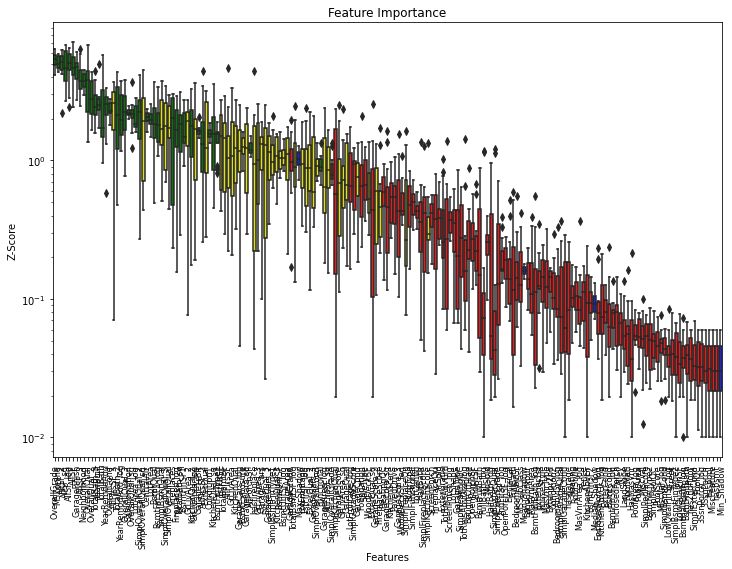

In [22]:
feat_selector.named_steps['model'].plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

In [ ]:
feat_selector.named_steps['model'].plot(which_features='accepted', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

In [ ]:
feat_selector.named_steps['model'].plot(which_features='tentative', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

In [24]:
for i in [20,21,26,31]:
    cols = feat_selector.named_steps['model'].runs[i]['selected']
    print(i)
    test_model(get_pipeline(LassoCV()),train_x=train_x[cols])


20
(1414, 119)
test 0.1064812, train 0.0978725
21
(1414, 122)
test 0.1064824, train 0.0978701
26
(1414, 124)
test 0.1064845, train 0.0978701
31
(1414, 119)
test 0.1064592, train 0.0978453


In [33]:

# with open('output/'+'res', 'wb') as handle:
#         pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)
f = open("output/feat_selection.pickle","rb")
cols = pickle.load(f)

['TotalBath_3',
 'BsmtFinSF1_log',
 'SaleCondition',
 'LotArea_log',
 'TotalBath_sq',
 'YearRemodAdd',
 'SimplOverallQual_2',
 'AllSF_2',
 'KitchenQual_2',
 'Fireplaces',
 'GarageFinish',
 'Fireplaces_log',
 'OverallQual',
 'CentralAir',
 'OverallQual_sq',
 'OverallQual_3',
 'AllPorchSF',
 'AllSF_3',
 'AllSF',
 'MSZoning',
 'OverallGrade',
 'LotArea',
 'BsmtQual',
 'YearRemodAdd_log',
 'AllSF_log',
 'YearBuilt',
 'Neighborhood',
 'TotalBath',
 'OverallCond',
 'Condition1',
 'GarageYrBlt',
 'OverallQual_2',
 'AllSF_sq',
 'BsmtFinSF1',
 'TotalBath_3',
 'GarageQual',
 'YearRemodAdd',
 'SimplOverallQual_2',
 'GrLivArea',
 'GarageFinish',
 'Fireplaces_log',
 'OverallQual',
 'GarageCars',
 'Neighborhood',
 'SimplOverallCond',
 'SimplKitchenScore',
 'KitchenQual_sq',
 'GrLivArea_log',
 'GarageCars_sq',
 'Condition1',
 'TotalBath_2',
 'GarageArea',
 'AllSF_2',
 'GarageCars_2',
 'Fireplaces',
 'KitchenQual_3',
 'GarageArea_log',
 'OverallQual_3',
 'OverallQual_sq',
 'AllSF',
 'BsmtUnfSF_log',
 'MSZoning',
 'LotArea',
 'YearRemodAdd_log',
 'ExterQual',
 'TotalBath',
 'TotalBsmtSF_log',
 'OverallQual_2',
 'AllFlrsSF_2',
 'AllFlrsSF_3',
 'LotFrontage',
 'SimplOverallQual_sq',
 'GrLivArea_2',
 'SimplBsmtFinType1',
 'WoodDeckSF',
 'SimplOverallQual',
 'BsmtFinSF1_log',
 'hasfireplace',
 'BsmtUnfSF',
 'GrLivArea_3',
 'SimplBsmtQual',
 'GarageCars_log',
 'GarageScore',
 'AllPorchSF',
 'HeatingQC',
 'AllSF_3',
 'OverallGrade',
 'GrLivArea_sq',
 'KitchenQual',
 'SimplOverallQual_3',
 'OverallCond',
 'GarageYrBlt',
 'AllSF_sq',
 'Foundation',
 'ExterQual_3',
 'LotArea_log',
 'SaleCondition',
 'ExterQual_2',
 'TotalBath_sq',
 'AllFlrsSF_sq',
 'GarageCars_3',
 'KitchenQual_2',
 'GarageCond',
 'CentralAir',
 'BsmtQual',
 'AllSF_log',
 'SimplFireplaceQu',
 'YearBuilt',
 'AllFlrsSF',
 '1stFlrSF_log',
 'BsmtExposure',
 'TotalBsmtSF',
 'Functional',
 'ExterQual_sq',
 '1stFlrSF',
 'FireplaceScore',
 'GarageScore_2',
 'BsmtFinType1',
 'BsmtFinSF1']

In [12]:
a = {}
if a: print('bla')
